# GRU - 许巍歌词生成

本notebook使用GRU模型训练许巍歌词数据，实现中文歌词生成。

In [1]:
# 预设置代码 - 纯PyTorch实现
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import collections
import random
import os
import glob
import time
import matplotlib.pyplot as plt

# ============ 1. 许巍歌词数据路径 ============
lyrics_dir = './许巍_5770'
print(f"使用本地歌词目录: {lyrics_dir}")

# ============ 2. 读取歌词数据 ============
def read_xuwei_lyrics():
    """读取目录下所有txt文件"""
    all_lines = []
    txt_files = glob.glob(os.path.join(lyrics_dir, '*.txt'))
    print(f"找到 {len(txt_files)} 个歌词文件")
    for txt_file in txt_files:
        with open(txt_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            all_lines.extend([line.strip() for line in lines if line.strip()])
    return all_lines

# ============ 3. 词表类 ============
class Vocab:
    def __init__(self, tokens=None, min_freq=0):
        tokens = tokens or []
        counter = collections.Counter([t for line in tokens for t in line])
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx_to_token = ['<unk>']
        self.token_to_idx = {'<unk>': 0}
        for token, freq in self._token_freqs:
            if freq >= min_freq and token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, 0)
        return [self[t] for t in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[i] for i in indices]

# ============ 4. 数据加载 ============
def load_corpus():
    lines = read_xuwei_lyrics()
    tokens = [list(line) for line in lines]  # 字符级分词
    vocab = Vocab(tokens)
    corpus = [vocab[t] for line in tokens for t in line]
    return corpus, vocab

# ============ 5. 序列数据迭代器 ============
def seq_data_iter(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens]).reshape(batch_size, -1)
    Ys = torch.tensor(corpus[offset + 1: offset + num_tokens + 1]).reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

# ============ 6. GRU模型 ============
class GRUModel(nn.Module):
    def __init__(self, vocab_size, num_hiddens, num_layers=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.gru = nn.GRU(vocab_size, num_hiddens, num_layers)
        self.linear = nn.Linear(num_hiddens, vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size).float()
        Y, state = self.gru(X, state)
        output = self.linear(Y.reshape(-1, Y.shape[-1]))
        return output, state
    
    def begin_state(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.num_hiddens, device=device)

# ============ 7. 预测函数 ============
def predict(prefix, num_preds, model, vocab, device):
    model.eval()
    state = model.begin_state(1, device)
    outputs = [vocab[prefix[0]]]
    
    with torch.no_grad():
        for y in prefix[1:]:
            x = torch.tensor([[outputs[-1]]], device=device)
            _, state = model(x, state)
            outputs.append(vocab[y])
        
        for _ in range(num_preds):
            x = torch.tensor([[outputs[-1]]], device=device)
            y, state = model(x, state)
            outputs.append(int(y.argmax(dim=1)))
    
    return ''.join(vocab.to_tokens(outputs))

# ============ 8. 训练函数 ============
def train(model, corpus, vocab, num_epochs, lr, batch_size, num_steps, device):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    history = []
    
    for epoch in range(num_epochs):
        model.train()
        state = None
        total_loss, total_tokens = 0, 0
        start_time = time.time()
        
        for X, Y in seq_data_iter(corpus, batch_size, num_steps):
            if state is None:
                state = model.begin_state(batch_size, device)
            else:
                state = state.detach()
            
            X, Y = X.to(device), Y.T.reshape(-1).to(device)
            y_hat, state = model(X, state)
            loss = loss_fn(y_hat, Y.long())
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item() * Y.numel()
            total_tokens += Y.numel()
        
        ppl = math.exp(total_loss / total_tokens)
        speed = total_tokens / (time.time() - start_time)
        history.append(ppl)
        
        if (epoch + 1) % 50 == 0:
            print(f'epoch {epoch+1}, 困惑度 {ppl:.1f}, {speed:.0f} tokens/sec')
            print(f'  生成: {predict("我的", 30, model, vocab, device)}')
    
    # 绘制训练曲线
    plt.figure(figsize=(8, 4))
    plt.plot(history)
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Training Progress')
    plt.grid(True)
    plt.show()
    
    return history

# 加载数据
corpus, vocab = load_corpus()
print(f'语料库大小: {len(corpus)}, 词表大小: {len(vocab)}')

使用本地歌词目录: ./许巍_5770
找到 67 个歌词文件
语料库大小: 17260, 词表大小: 1111


In [2]:
# 超参数设置
batch_size = 32
num_steps = 25
num_hiddens = 256
num_layers = 1
num_epochs = 500
lr = 1.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'设备: {device}')
print(f'批次大小: {batch_size}, 时间步: {num_steps}')
print(f'隐藏单元: {num_hiddens}, 层数: {num_layers}')
print(f'训练轮数: {num_epochs}, 学习率: {lr}')

设备: cpu
批次大小: 32, 时间步: 25
隐藏单元: 256, 层数: 1
训练轮数: 500, 学习率: 1.0


模型参数量: 1,336,919
epoch 50, 困惑度 152.7, 44611 tokens/sec
  生成: 我的心里我们到你在我心里我想到你在我心里我想到你在我心里我想到你
epoch 100, 困惑度 12.3, 44519 tokens/sec
  生成: 我的心又是这个世界自在我怀里你曾有着明天的心就是你在身边中顶天边
epoch 150, 困惑度 1.8, 44629 tokens/sec
  生成: 我的心曾乘着风啊自由穿行梦想里啊我沉默地祈祷啊感受着你的光芒感觉
epoch 200, 困惑度 1.1, 44707 tokens/sec
  生成: 我的心曾乘着风啊自由穿行梦想里啊我沉默地祈祷啊感受着你的光芒感觉
epoch 250, 困惑度 1.1, 42366 tokens/sec
  生成: 我的心却那么狂野你在我的心里永远是故乡你总为我独自守候沉默等待在
epoch 300, 困惑度 1.1, 41568 tokens/sec
  生成: 我的心曾乘着风啊自由穿行梦想里啊我沉默地祈祷啊感受着你的光芒感觉
epoch 350, 困惑度 1.1, 42039 tokens/sec
  生成: 我的心曾乘着风啊自由穿行梦想里啊我沉默地祈祷啊感受着你的光芒感觉
epoch 400, 困惑度 1.0, 45066 tokens/sec
  生成: 我的心却那么狂野你在我的心里永远是故乡你总为我独自守候沉默等待在
epoch 450, 困惑度 1.0, 43081 tokens/sec
  生成: 我的心却那么狂野你在我的心里永远是故乡你总为我独自守候沉默等待在
epoch 500, 困惑度 1.0, 45122 tokens/sec
  生成: 我的心却那么狂野你在我的心里永远是故乡你总为我独自守候沉默等待在


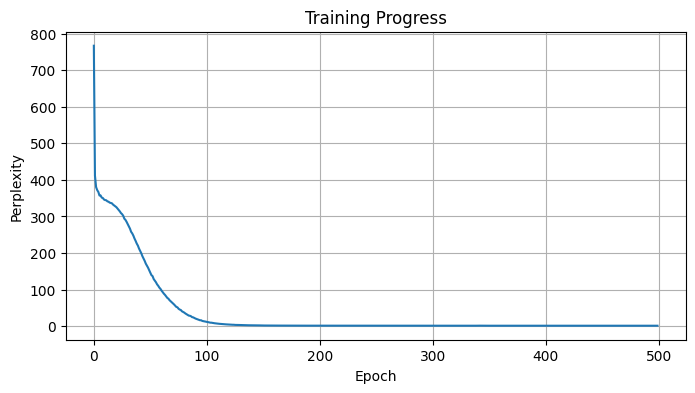

In [3]:
# 创建模型并训练
model = GRUModel(len(vocab), num_hiddens, num_layers)
print(f'模型参数量: {sum(p.numel() for p in model.parameters()):,}')

# 开始训练
history = train(model, corpus, vocab, num_epochs, lr, batch_size, num_steps, device)

In [4]:
# 歌词生成测试
print("=" * 50)
print("许巍风格歌词生成:")
print("=" * 50)

prefixes = ['曾经', '我的', '蓝莲花', '生活', '你的', '那一']
for prefix in prefixes:
    generated = predict(prefix, 50, model, vocab, device)
    print(f"'{prefix}': {generated}")
    print()

许巍风格歌词生成:
'曾经': 曾经过的目光 只失在人口间间着你醒来如果有爱就还有分暗的时光总在夕阳与你轻盈旋转你让我分永远离着我多想看

'我的': 我的心却那么狂野你在我的心里永远是故乡你总为我独自守候沉默等待在异乡的路上每一个寒冷的夜晚这思念它如刀让

'蓝莲花': 蓝莲花海常的山晚梵执拗的名字 诉说坚持 一生只要这纯粹火焰的花蕊 无视隐晦 助长坚强的芬菲你灿烂的笑着 我

'生活': 生活我多想看到你那依旧灿烂的笑容再一次释放自己呜～～呜～～啊~此刻谁在茫茫人海之中在这浩瀚的宇宙蓝色的城

'你的': 你的笑容此温暖我如此江这对初世的自己是你灿烂的笑容让我感觉到人你曾有的力量就像春天不再一切我独自在人里想

'那一': 那一些隐约在我心间伴随我想你的今天你让我长久沉重的心感到从没有的轻盈我爱丽江夜晚熊熊的篝火我们歌唱跳舞快

